In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns

from tqdm.auto import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pingouin as pg
from scipy import stats

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Задача 1.

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения.
В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

In [30]:
reg_date = pd.read_csv('shared/problem1-reg_data.csv', sep=';')
entry_date = pd.read_csv('shared/problem1-auth_data.csv', sep=';')

Начну с краткого анализа датафреймов.
Проверю типы данных, наличие пропусков, совпадает ли количество уникальных пользователей в дф с регистрациями и заходами пользователей в игру.

In [31]:
reg_date.dtypes

reg_ts    int64
uid       int64
dtype: object

In [32]:
reg_date.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [33]:
reg_date['reg_ts'].nunique()

1000000

In [34]:
reg_date['uid'].nunique()

1000000

In [37]:
entry_date.dtypes

auth_ts    int64
uid        int64
dtype: object

In [38]:
entry_date.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [39]:
entry_date['auth_ts'].nunique()

9180915

In [40]:
entry_date['uid'].nunique()

1000000

Пропусков нет, типы данных нужно будет привести к datetime. 
Интересует retention по дням от даты регистрации, буду делать когортный анализ на части данных, точнее, анализ последнего месяца. 

In [13]:
# на вход функции даем 2 дф и дату, с которой будем считать retention
def cohort_analysis(reg_date, entry_date, d):
    reg_date['reg_ts'] = pd.to_datetime(reg_date['reg_ts'], unit = 's') # привожу колонки со временем к datetime
    entry_date['auth_ts'] = pd.to_datetime(entry_date['auth_ts'], unit = 's')
    df = entry_date.merge(reg_date, how='left', on='uid') # соединяю дф по номерам id
    df['auth_ts'] = df['auth_ts'].apply(lambda x: x.strftime('%Y-%m-%d')) # оставляю только дату в колонках со временем
    df['reg_ts'] = df['reg_ts'].apply(lambda x: x.strftime('%Y-%m-%d'))
    df['auth_ts'] = pd.to_datetime(df['auth_ts'])
    df['reg_ts'] = pd.to_datetime(df['reg_ts'])
    df = df[df['reg_ts'] > d] # оставляю часть данных, по ктр буду считать retention
    df['cohort_index'] = (df['auth_ts'] - df['reg_ts']).dt.days # создаю колонку с разницей в днях между регистрацией и заходом в игру
    piv_table = df.pivot_table(index='reg_ts', columns='cohort_index', values='uid', aggfunc='count') 
    piv_table = piv_table.divide(piv_table.iloc[:,0], axis=0) \
                    .round(4) # делю дф на количество пользователей в когорте, чтобы получить долю "вернувшихся" пользователей
    ur_style = (piv_table # творим "стиль" как учили в 8 уроке по питону(:
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    return ur_style

In [46]:
d = '2020-09-01'

In [14]:
cohort_analysis(reg_date, entry_date, d)

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
reg_ts,,,,,,,,,,,,,,,,,,,,,,
2020-09-02 00:00:00,100.00%,2.52%,3.90%,4.66%,5.67%,6.23%,7.12%,6.30%,4.85%,4.09%,5.67%,5.48%,5.48%,4.35%,4.97%,5.29%,4.16%,4.85%,3.90%,3.72%,4.66%,2.64%
2020-09-03 00:00:00,100.00%,2.33%,5.41%,4.71%,6.54%,6.98%,8.55%,6.35%,5.47%,6.29%,6.35%,5.53%,5.85%,5.97%,5.47%,5.34%,4.40%,4.84%,4.65%,5.47%,2.39%,
2020-09-04 00:00:00,100.00%,2.01%,3.64%,3.64%,5.15%,6.40%,7.28%,4.96%,5.34%,4.33%,5.65%,5.52%,4.33%,5.59%,4.39%,4.52%,4.52%,4.27%,4.77%,2.64%,,
2020-09-05 00:00:00,100.00%,2.76%,3.95%,4.64%,5.45%,5.89%,7.46%,4.89%,5.08%,5.45%,6.02%,5.20%,4.57%,5.39%,4.51%,5.14%,4.45%,4.76%,2.51%,,,
2020-09-06 00:00:00,100.00%,3.13%,4.32%,5.44%,5.63%,5.88%,6.82%,6.07%,5.82%,5.50%,4.88%,4.75%,5.38%,5.19%,5.50%,4.57%,4.82%,2.56%,,,,
2020-09-07 00:00:00,100.00%,2.94%,4.25%,5.37%,5.06%,6.37%,7.31%,5.25%,4.12%,5.62%,6.00%,5.68%,4.56%,5.06%,4.25%,5.06%,3.37%,,,,,
2020-09-08 00:00:00,100.00%,1.75%,3.93%,3.93%,4.86%,7.61%,7.54%,6.61%,5.17%,5.17%,6.55%,5.36%,5.92%,5.17%,4.74%,3.05%,,,,,,
2020-09-09 00:00:00,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%,,,,,,,
2020-09-10 00:00:00,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%,,,,,,,,


Можно увидеть, что наибольший retention в течение выбранных для анализа 3х недель у пользователей, зарегистрировавшихся 2020-09-03. Сильные спады или всплески активности у пользователей незаметны, меньше всего людей заходит в игру на следующий день после регистрации.

### Задача 2.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
df_2 = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

Проведу краткий анализ данных:

In [8]:
df_2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
df_2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [5]:
df_2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Сравню средний чек в обеих группах:

In [10]:
df_2.groupby('testgroup').agg({'revenue':'mean'})

,revenue
testgroup,
a,25.413720
b,26.751287


Судя по среднему чеку, тестовой является группа В. Чтоб понять, является разница в  ARPU в 5% статзначимой, буду сравнивать средние чеки в обеих группах. Идею с медианами/квантилями отмела, так как платящих пользователей в обеих группах меньше процента, медиана будет равно 0, на мой взгляд средний чек наглядней при сравнении. 

Посмотрю на распределение чеков по группам с помощью дистплота и QQ-плота:

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


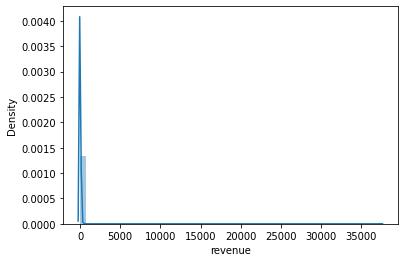

In [79]:
sns.distplot(df_2.loc[(df_2['testgroup'] == 'a')]['revenue'])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


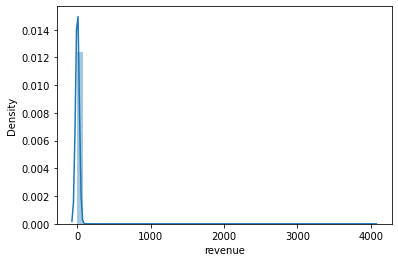

In [80]:
sns.distplot(df_2.loc[(df_2['testgroup'] == 'b')]['revenue'])

In [14]:
a = df_2.loc[(df_2['testgroup'] == 'a')]['revenue'] # чеки контрольной группы

In [15]:
b = df_2.loc[(df_2['testgroup'] == 'b')]['revenue'] # чеки тестовой группы

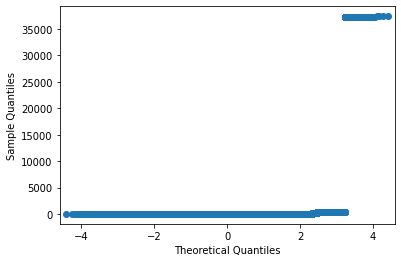

In [17]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(a)
plt.show()

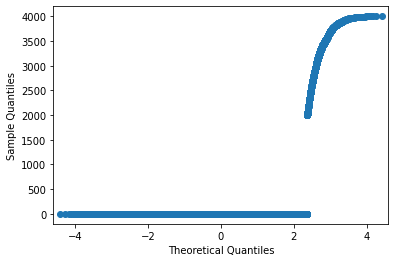

In [16]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(b)
plt.show()

Судя по графикам, выручка по пользователям распределена ненормально.
Проверю далее гомоскедастичность распределений:

In [20]:
pg.homoscedasticity(data=df_2, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


Итак, распределения гомоскедастичны, ненормальны, выборка - довольно большая, что позволяет мне выбрать t-test для сравнения средних и определения статзначимости различий.
Думала так же о бутстрапе, но, учитывая, что я сравниваю только средние и у меня большие выборки, решила остановиться на t-test, хотя, по большому счету могла, наверно, выбрать и бутстрап:) 

In [25]:
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Результат t-test говорит о том, что различия в двух группах вероятно случайны, p-value > 0.05 и нельзя говорить о том, что наборы акционных предложений для тестовой группы были эффективней, учитывая, что и соотношение платящих к неплатящим пользователям в контрольной группе больше.

### Задача 3.

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Я бы использовала следующие метрики при анализе последнего прошедшего события:


**Дневная аудитория (DAU)** — количество уникальных пользователей, которые зашли в приложение в течение суток. Посмотреть, какое количество уникальных пользователей приклекли тематические события.

**Retention rate (RR)** - коэффициент удержания клиентов. Сравнила бы retention у пользователей, участвующих и не участвующих в событии, помогает ли это вообще удержанию. И так же  можно было бы посчитать процент пользователей, вернувшихся после первой  неудачной попытки. Это поможет оценить, насколько успешно событие удерживает пользователей после неудач.

**Churn Rate (отток)** - Процент пользователей, переставших участвовать в событии. 

Если в игре есть монетизация: **ARPU** - Средняя выручка с одного пользователя. Это поможет понять, сколько среднего дохода получаем от каждого пользователя, участвующего в событии.

**Время, проведенное пользователями в игре во время события.** Это не совсем метрика, но оценка среднего времени, проведенного пользователями в игре во время события, может дать представление о вовлеченности игроков.




При усложнении механики события, я бы добавила еще пару метрик:



**Уровни, пройденные до отката** - оценить, сколько уровней игроки проходили до отката. Это поможет определить, на каком уровне игроки чаще всего сталкиваются с трудностями.

**Churn Rate (отток)** - Изменение механики может повлиять на отток пользователей. Стоит посчитать, сколько уже участвовавших в событии уходят из игры после усложнения. Усложнение механики может привести к большему оттоку, так как некоторые игроки могут столкнуться с фрустрацией и прекратить участие.

**LTV (Customer Lifetime Value)** - Сложность механики события может повлиять на долгосрочную ценность пользователей. Если они активно участвуют и продолжают попытки после неудач, их LTV может возрасти.


**Оценка удовлетворенности клиентов (customer satisfaction score, CSAT)** — измеряет общий уровень недовольства пользователя по поводу определенного продукта или функции. Было бы неплохо посмотреть среди тех, кто вообще не участвовал в событии, участвовал без усложнения и участвовал с усложнением механики.
